In [20]:
from google.colab import drive
drive.mount('/content/drive')
!pip install datasets --quiet

import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 데이터셋 경로 설정
data_path = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/data/'  # 이미지 및 텍스트 파일 폴더

# 텍스트 전처리 함수
def preprocess_text(text):
    text = text.lower()  # 소문자로 변환
    text = ''.join(e for e in text if e.isalnum() or e.isspace())  # 특수문자 제거
    return text

# 커스텀 데이터셋 클래스 정의
class ImageTextDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.data = []

        # 폴더 내 파일 목록 가져오기
        file_names = [f.split('.')[0] for f in os.listdir(folder_path) if f.endswith('.jpg')]  # .jpg 파일 기준
        unique_ids = set(file_names)  # 중복 제거

        for file_id in unique_ids:
            # 이미지와 텍스트 파일 경로 생성
            image_file = os.path.join(folder_path, f"{file_id}.jpg")
            text_file = os.path.join(folder_path, f"{file_id}.txt")

            # 이미지와 텍스트 파일이 모두 있는 경우 로드
            if os.path.exists(image_file) and os.path.exists(text_file):
                self.data.append((image_file, text_file))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_file, text_file = self.data[idx]

        # 이미지 로드 및 전처리
        image = cv2.imread(image_file)
        if image is None:
            raise ValueError(f"이미지를 로드할 수 없습니다: {image_file}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환

        if self.transform:
            image = self.transform(image)
        else:
            # 기본 변환 적용
            image = cv2.resize(image, (224, 224))
            image = image / 255.0  # 정규화
            image = torch.tensor(image, dtype=torch.float32)
            image = image.permute(2, 0, 1)  # (H, W, C) -> (C, H, W)

        # 텍스트 로드 및 전처리
        with open(text_file, 'r') as file:
            raw_text = file.read().strip()
        text = preprocess_text(raw_text)

        return image, text

# 데이터셋 및 데이터로더 생성
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = ImageTextDataset(data_path, transform=transform)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

## 2. 모델과 라벨 1차 평가

In [22]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from collections import Counter
from sklearn.metrics import classification_report

# 1. 라벨 파일 로드 및 전처리
label_file_path = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/label.txt'

# 라벨 파일 로드
label_df = pd.read_csv(label_file_path, sep='\t', header=0)

# 컬럼 이름 지정 (필요에 따라)
label_df.columns = ['ID', 'Annotator1', 'Annotator2', 'Annotator3']

# 감성 라벨 매핑
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# 각 샘플에 대한 라벨러들의 라벨 수집
all_labels = []
sample_ids = label_df['ID'].tolist()
for idx, row in label_df.iterrows():
    labels = []
    for annotator in ['Annotator1', 'Annotator2', 'Annotator3']:
        text_label = row[annotator].split(',')[0].strip()  # 텍스트 라벨 추출
        labels.append(text_label)
    # 라벨 매핑 적용
    mapped_labels = [label_mapping[label] for label in labels]
    all_labels.append(mapped_labels)  # 각 샘플에 대한 세 명의 라벨러 라벨 저장

In [23]:
# 2. 모델 로드
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"  # 예시 모델 이름
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# GPU 사용 설정 (가능한 경우)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()  # 평가 모드로 설정

# 3. 예측 수행
predicted_labels = []
valid_sample_ids = []
valid_all_labels = []

# 진행 상황 모니터링을 위한 설정
total_samples = len(sample_ids)
print(f"총 샘플 수: {total_samples}")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


총 샘플 수: 19600


### 로컬로 파일 옮기기(자기전에돌려둘것)



In [25]:
!apt-get update
!apt-get install -y rsync

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,619 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,513 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packa

In [ ]:
source_path = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/data/'
destination_path = '/content/data/'

# 데이터 디렉토리가 존재하지 않으면 생성
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

# rsync 명령어 실행
!rsync -avh --progress "{source_path}" "{destination_path}"


In [27]:
import os

directory_path = '/content/data/'

# 특정 확장자(.jpg)를 가진 파일만 선택
file_list = [f for f in os.listdir(directory_path) if f.endswith('.jpg') and os.path.isfile(os.path.join(directory_path, f))]

print(f"'{directory_path}' 디렉토리 내 '.jpg' 파일 수: {len(file_list)}개")



'/content/data/' 디렉토리 내 '.jpg' 파일 수: 1281개


## csv를 통한 처리

In [ ]:
import os
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/data/'
sample_ids = label_df['ID'].tolist()

texts = []
valid_sample_ids = []

for idx, sample_id in enumerate(sample_ids):
    text_file = os.path.join(data_path, f"{sample_id}.txt")
    if idx%100 == 0:
      print(idx)
    if os.path.exists(text_file):
        with open(text_file, 'r', encoding='utf-8') as file:
            raw_text = file.read().strip()
        texts.append({'ID': sample_id, 'Text': raw_text})
        valid_sample_ids.append(sample_id)
    else:
        print(f"{sample_id}.txt 파일을 찾을 수 없습니다.")

# 텍스트 데이터를 DataFrame으로 변환
texts_df = pd.DataFrame(texts)

# CSV 파일로 저장
texts_df.to_csv('/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/texts.csv', index=False)


In [34]:
# 텍스트 데이터 로드
texts_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/texts.csv')


In [36]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [38]:
texts_df['Text'] = texts_df['Text'].apply(preprocess)

In [39]:
# 라벨 데이터와 텍스트 데이터 병합
merged_df = pd.merge(label_df, texts_df, on='ID')

In [47]:
from tqdm import tqdm
from collections import Counter
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름 정의
class_names = ['Negative', 'Neutral', 'Positive']

predicted_labels = []
majority_labels = []
predicted_probabilities = []

for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Processing"):
    raw_text = row['Text']
    labels = []
    for annotator in ['Annotator1', 'Annotator2', 'Annotator3']:
        text_label = row[annotator].split(',')[0].strip()
        labels.append(text_label)
    # 라벨 매핑 적용
    mapped_labels = [label_mapping[label] for label in labels]
    # 다수결 라벨 계산
    label_counts = Counter(mapped_labels)
    majority_label = label_counts.most_common(1)[0][0]
    majority_labels.append(majority_label)

    # 텍스트 토크나이즈
    inputs = tokenizer(
        raw_text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        predicted_labels.append(predicted_class)
        predicted_probabilities.append(probs.cpu().numpy())


Processing: 100%|██████████| 19600/19600 [02:57<00:00, 110.39it/s]


              precision    recall  f1-score   support

    Negative       0.41      0.42      0.41      1491
     Neutral       0.53      0.62      0.57      7698
    Positive       0.71      0.62      0.66     10411

    accuracy                           0.60     19600
   macro avg       0.55      0.55      0.55     19600
weighted avg       0.61      0.60      0.61     19600



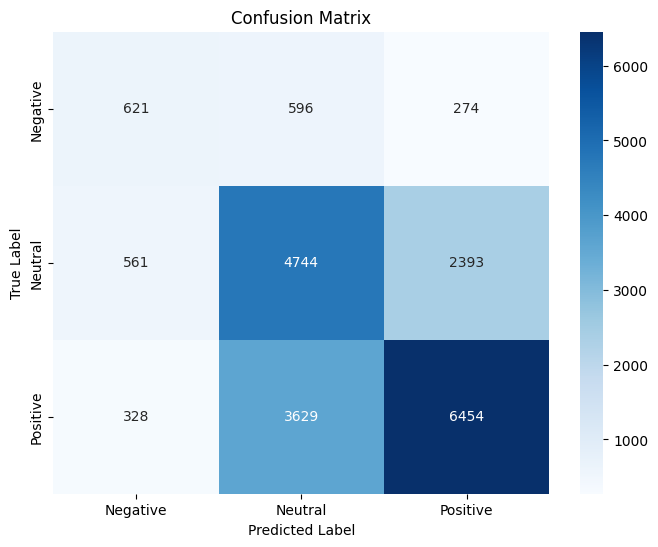

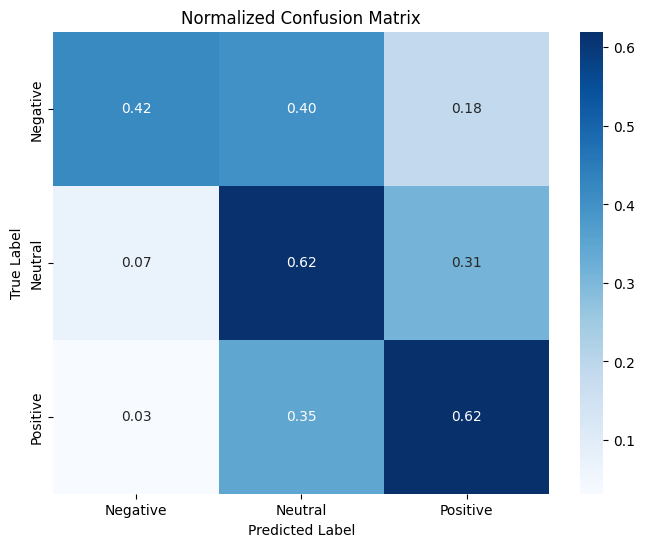

잘못 분류된 샘플 수: 7781

샘플 인덱스: 0
텍스트: Knocked doors with the venerable #TeamTrudeau #lpc candidate @user this aft in my hometown, Aurora! #elxn42
실제 라벨: Positive
예측 라벨: Neutral

샘플 인덱스: 3
텍스트: ""I think it's time for change"" - Ana Commit to Vote: #GenerationTrudeau #SFU #LPC #elxn42 http
실제 라벨: Positive
예측 라벨: Neutral

샘플 인덱스: 4
텍스트: The Past and Future of the Refugee Crisis - Thomas Sowell #elxn42 #polqc http
실제 라벨: Positive
예측 라벨: Neutral

샘플 인덱스: 8
텍스트: The end of the road and destined for the scrap heap #HarperBus #Canada #cdnpoli #elxn42
실제 라벨: Neutral
예측 라벨: Negative

샘플 인덱스: 9
텍스트: ?? Who is who and does what in the #elxn42 Conservative War Room? #CPC #CDNpoli #CANpoli http
실제 라벨: Negative
예측 라벨: Neutral

첫 번째 샘플의 클래스별 확률 분포:
Negative: 0.0421
Neutral: 0.7623
Positive: 0.1956


In [48]:
# 1. 분류 보고서 출력
print(classification_report(majority_labels, predicted_labels, target_names=class_names))

# 2. 혼동 행렬 시각화
cm = confusion_matrix(majority_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 3. 정규화된 혼동 행렬 시각화
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

# 4. 잘못 분류된 샘플 확인
misclassified_indices = []

for i, (true_label, pred_label) in enumerate(zip(majority_labels, predicted_labels)):
    if pred_label != true_label:
        misclassified_indices.append(i)

print(f"잘못 분류된 샘플 수: {len(misclassified_indices)}")

# 잘못 분류된 샘플 중 일부를 출력
num_samples_to_show = 5  # 표시할 샘플 수

for idx in misclassified_indices[:num_samples_to_show]:
    print(f"\n샘플 인덱스: {idx}")
    print(f"텍스트: {merged_df.iloc[idx]['Text']}")
    true_label = class_names[majority_labels[idx]]
    pred_label = class_names[predicted_labels[idx]]
    print(f"실제 라벨: {true_label}")
    print(f"예측 라벨: {pred_label}")

# 5. 예시로 첫 번째 샘플의 확률 분포 출력
first_sample_probs = predicted_probabilities[0][0]
print(f"\n첫 번째 샘플의 클래스별 확률 분포:")
for i, prob in enumerate(first_sample_probs):
    print(f"{class_names[i]}: {prob:.4f}")

In [49]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름 정의
class_names = ['Negative', 'Neutral', 'Positive']

predicted_labels = []
valid_all_labels = []
predicted_probabilities = []

for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Processing"):
    raw_text = row['Text']
    labels = []
    for annotator in ['Annotator1', 'Annotator2', 'Annotator3']:
        text_label = row[annotator].split(',')[0].strip()
        labels.append(text_label)
    # 라벨 매핑 적용
    mapped_labels = [label_mapping[label] for label in labels]
    valid_all_labels.append(mapped_labels)

    # 텍스트 토크나이즈
    inputs = tokenizer(
        raw_text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        predicted_labels.append(predicted_class)
        predicted_probabilities.append(probs.cpu().numpy())

# 1. 평가 기준 적용 (하나라도 일치하면 정답으로 간주)

correct = 0
total = len(predicted_labels)

for i in range(total):
    true_labels = valid_all_labels[i]  # 세 명의 라벨러 라벨
    pred_label = predicted_labels[i]   # 모델의 예측 라벨
    if pred_label in true_labels:
        correct += 1

accuracy = correct / total
print(f"\n모델의 정확도 (하나라도 일치): {accuracy * 100:.2f}%")



Processing: 100%|██████████| 19600/19600 [02:55<00:00, 111.41it/s]


모델의 정확도 (하나라도 일치): 86.22%


KeyError: 2


분류 보고서 (첫 번째 라벨러 기준):
              precision    recall  f1-score   support

    Negative       0.39      0.33      0.36      1800
     Neutral       0.51      0.57      0.54      8072
    Positive       0.64      0.60      0.62      9728

    accuracy                           0.56     19600
   macro avg       0.51      0.50      0.50     19600
weighted avg       0.56      0.56      0.56     19600



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48296 (\N{HANGUL SYLLABLE BEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IP

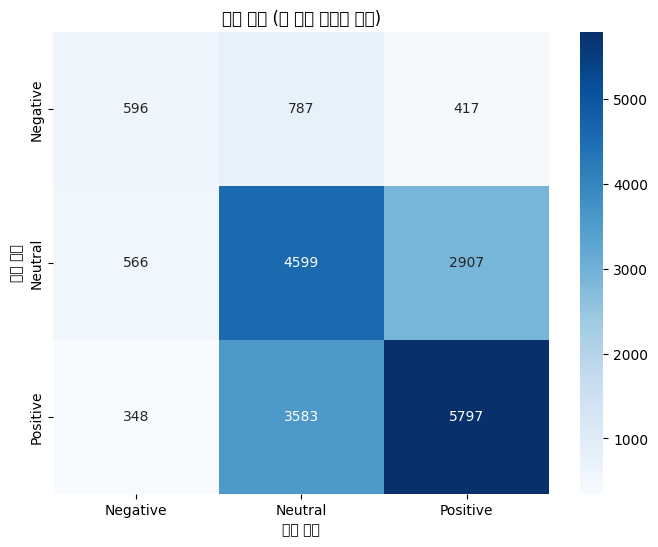


잘못 분류된 샘플 수: 2701

샘플 인덱스: 3
텍스트: ""I think it's time for change"" - Ana Commit to Vote: #GenerationTrudeau #SFU #LPC #elxn42 http
실제 라벨들: ['Positive', 'Positive', 'Positive']
예측 라벨: Neutral

샘플 인덱스: 4
텍스트: The Past and Future of the Refugee Crisis - Thomas Sowell #elxn42 #polqc http
실제 라벨들: ['Positive', 'Positive', 'Positive']
예측 라벨: Neutral

샘플 인덱스: 8
텍스트: The end of the road and destined for the scrap heap #HarperBus #Canada #cdnpoli #elxn42
실제 라벨들: ['Positive', 'Neutral', 'Neutral']
예측 라벨: Negative

샘플 인덱스: 9
텍스트: ?? Who is who and does what in the #elxn42 Conservative War Room? #CPC #CDNpoli #CANpoli http
실제 라벨들: ['Negative', 'Negative', 'Negative']
예측 라벨: Neutral

샘플 인덱스: 12
텍스트: Great AM with riding neighbors @user &amp; @user sharing our #LPC plan for #RealChange! #DVW #elxn42
실제 라벨들: ['Neutral', 'Neutral', 'Neutral']
예측 라벨: Positive


In [50]:

# 2. 혼동 행렬 시각화 (선택 사항)

# 실제 라벨을 각 샘플마다 세 개의 라벨이 아닌 단일 라벨로 가져와야 혼동 행렬을 그릴 수 있습니다.
# 여기서는 각 샘플마다 첫 번째 라벨러의 라벨을 사용하여 혼동 행렬을 그려보겠습니다.

# 기존 코드에서 해당 부분 수정
first_annotator_labels = [labels[0] for labels in valid_all_labels]

# 이 부분에서 추가적인 매핑 제거
# mapped_true_labels = [label_mapping[label] for label in first_annotator_labels]  # 이 줄 제거 또는 주석 처리

# 대신 mapped_true_labels를 first_annotator_labels로 설정
mapped_true_labels = first_annotator_labels

# 분류 보고서 출력
print("\n분류 보고서 (첫 번째 라벨러 기준):")
print(classification_report(mapped_true_labels, predicted_labels, target_names=class_names))

# 혼동 행렬 계산
cm = confusion_matrix(mapped_true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('예측 라벨')
plt.ylabel('실제 라벨')
plt.title('혼동 행렬 (첫 번째 라벨러 기준)')
plt.show()

# 3. 잘못 분류된 샘플 확인

misclassified_indices = []

for i in range(total):
    true_labels = valid_all_labels[i]
    pred_label = predicted_labels[i]
    if pred_label not in true_labels:
        misclassified_indices.append(i)

print(f"\n잘못 분류된 샘플 수: {len(misclassified_indices)}")

# 잘못 분류된 샘플 중 일부를 출력
num_samples_to_show = 5  # 표시할 샘플 수

for idx in misclassified_indices[:num_samples_to_show]:
    print(f"\n샘플 인덱스: {idx}")
    print(f"텍스트: {merged_df.iloc[idx]['Text']}")
    true_labels = [class_names[label] for label in valid_all_labels[idx]]
    pred_label = class_names[predicted_labels[idx]]
    print(f"실제 라벨들: {true_labels}")
    print(f"예측 라벨: {pred_label}")

## 모델 추가학습

In [51]:
from collections import Counter

# 다수결 라벨 계산 함수
def get_majority_label(labels):
    label_counts = Counter(labels)
    majority_label = label_counts.most_common(1)[0][0]
    return majority_label

# 데이터셋 생성
data = []
for idx, row in merged_df.iterrows():
    raw_text = row['Text']
    labels = []
    for annotator in ['Annotator1', 'Annotator2', 'Annotator3']:
        text_label = row[annotator].split(',')[0].strip()
        labels.append(text_label)
    # 라벨 매핑 적용
    mapped_labels = [label_mapping[label] for label in labels]
    # 다수결 라벨 계산
    majority_label = get_majority_label(mapped_labels)
    data.append({'text': raw_text, 'label': majority_label})


In [52]:
import pandas as pd

# 데이터프레임 생성
data_df = pd.DataFrame(data)

# CSV 파일로 저장
data_df.to_csv('dataset.csv', index=False)


In [53]:
from sklearn.model_selection import train_test_split

# 전체 데이터셋 로드
data_df = pd.read_csv('dataset.csv')

# 학습용과 임시 테스트용으로 먼저 분할
train_df, temp_df = train_test_split(data_df, test_size=0.2, random_state=42)

# 임시 테스트용을 다시 검증용과 테스트용으로 분할
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"학습 데이터 수: {len(train_df)}")
print(f"검증 데이터 수: {len(val_df)}")
print(f"테스트 데이터 수: {len(test_df)}")


학습 데이터 수: 15680
검증 데이터 수: 1960
테스트 데이터 수: 1960


In [54]:
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # 토크나이즈 및 인코딩
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        inputs = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

        return inputs


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"  # 기존에 사용한 모델 이름

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


In [56]:
from torch.utils.data import DataLoader

# 데이터셋 객체 생성
train_dataset = SentimentDataset(
    texts=train_df['text'].tolist(),
    labels=train_df['label'].tolist(),
    tokenizer=tokenizer
)

val_dataset = SentimentDataset(
    texts=val_df['text'].tolist(),
    labels=val_df['label'].tolist(),
    tokenizer=tokenizer
)

test_dataset = SentimentDataset(
    texts=test_df['text'].tolist(),
    labels=test_df['label'].tolist(),
    tokenizer=tokenizer
)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [57]:
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# 학습 스케줄러 설정
total_steps = len(train_loader) * 3  # 에포크 수에 따라 조정 (예: 3 에포크)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 손실 함수 설정
loss_fn = torch.nn.CrossEntropyLoss().to(device)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [58]:
import numpy as np

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader, desc="Training"):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating"):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [59]:
from tqdm import tqdm

EPOCHS = 3

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')



Epoch 1/3
----------


Training: 100%|██████████| 490/490 [02:19<00:00,  3.51it/s]


Train loss 0.8002933454756834 accuracy 0.5963010204081634


Evaluating: 100%|██████████| 62/62 [00:06<00:00,  9.90it/s]


Validation loss 0.755511753020748 accuracy 0.6423469387755103

Epoch 2/3
----------


Training: 100%|██████████| 490/490 [02:18<00:00,  3.54it/s]


Train loss 0.6806578916554549 accuracy 0.6857142857142857


Evaluating: 100%|██████████| 62/62 [00:06<00:00, 10.07it/s]


Validation loss 0.7753163302137006 accuracy 0.6311224489795919

Epoch 3/3
----------


Training: 100%|██████████| 490/490 [02:18<00:00,  3.54it/s]


Train loss 0.574734527845772 accuracy 0.7504464285714286


Evaluating: 100%|██████████| 62/62 [00:06<00:00, 10.00it/s]

Validation loss 0.8523395744062239 accuracy 0.6224489795918368


In [60]:
test_acc, _ = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_dataset)
)

print(f'\nTest Accuracy: {test_acc.item() * 100:.2f}%')


Evaluating: 100%|██████████| 62/62 [00:06<00:00, 10.08it/s]


Test Accuracy: 61.07%


In [61]:
from sklearn.metrics import classification_report

def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Predicting"):
            texts.extend(d["input_ids"].tolist())
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            _, preds = torch.max(probs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values

y_pred, y_probs, y_test = get_predictions(model, test_loader)

print(classification_report(y_test, y_pred, target_names=class_names))


Predicting: 100%|██████████| 62/62 [00:06<00:00, 10.04it/s]

              precision    recall  f1-score   support

    Negative       0.48      0.39      0.43       157
     Neutral       0.55      0.47      0.51       758
    Positive       0.66      0.75      0.70      1045

    accuracy                           0.61      1960
   macro avg       0.56      0.53      0.54      1960
weighted avg       0.60      0.61      0.60      1960



Processing: 100%|██████████| 1673/1673 [00:15<00:00, 108.33it/s]
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48296 (\N{HANGUL SYLLABLE BEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from current font.
  fig.canvas.print_


모델의 정확도 (하나라도 일치): 75.07%

잘못 분류된 샘플 수: 417

샘플 인덱스: 0
텍스트: Here's @user shaking hands with @user at today's #HamOnt rally
실제 라벨들: ['Neutral', 'Negative', 'Neutral']
예측 라벨: Positive

샘플 인덱스: 8
텍스트: Good morning, St. John's, NL. #Canada http
실제 라벨들: ['Neutral', 'Neutral', 'Neutral']
예측 라벨: Positive

샘플 인덱스: 10
텍스트: #love how this piece looks above this #red bench. Super fun &amp; happy clients?? in #yeg
실제 라벨들: ['Neutral', 'Neutral', 'Neutral']
예측 라벨: Positive

샘플 인덱스: 18
텍스트: It's a big series between #BlueJays and #Rangers, so @user and @user break it all down:http://t.co/IJGxgVQpzF
실제 라벨들: ['Positive', 'Positive', 'Positive']
예측 라벨: Neutral

샘플 인덱스: 23
텍스트: #LastChance for $25 #EarlyBird #Oktoberfest #Tickets- Just like #Toronto Gas, Prices are Going Up at #Midnight! #RT
실제 라벨들: ['Positive', 'Positive', 'Positive']
예측 라벨: Neutral

분류 보고서 (첫 번째 라벨러 기준):
              precision    recall  f1-score   support

    Negative       0.08      0.06      0.07       156
     Neutral       0.43

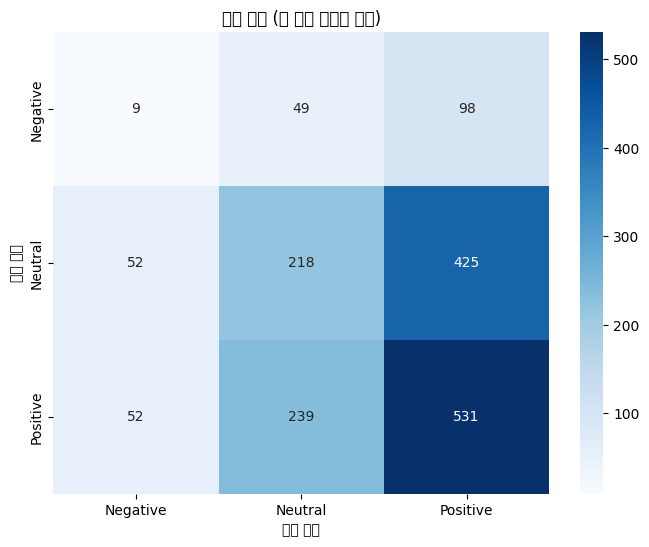

In [69]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. 미세 조정된 모델과 토크나이저 로드
model_path = 'fine_tuned_model'  # 모델이 저장된 경로를 지정하세요

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# GPU 사용 설정 (가능한 경우)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()  # 평가 모드로 설정

# 2. 테스트 데이터 준비
# 이전에 데이터셋을 나눴을 때 저장한 test_df를 사용한다고 가정합니다.

# 만약 test_df를 저장했다면 로드합니다.
# test_df = pd.read_csv('test_dataset.csv')  # 저장한 경로로 변경하세요

# 또는 이전에 나눴던 test_df를 그대로 사용합니다.

# 테스트 데이터에서 텍스트와 라벨 가져오기
# 라벨 파일 로드 및 전처리 (라벨러들의 라벨 포함)

label_file_path = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/label.txt'
label_df = pd.read_csv(label_file_path, sep='\t', header=0)
label_df.columns = ['ID', 'Annotator1', 'Annotator2', 'Annotator3']

# 테스트 데이터와 라벨 데이터 병합
# 1. test_df의 인덱스를 리셋하여 'id'를 컬럼으로 만듭니다.
test_df = test_df.reset_index()

# 2. 'id' 컬럼의 이름을 'ID'로 변경하여 label_df와 일치시킵니다.
test_df = test_df.rename(columns={'index': 'ID'})

# 3. 이제 'ID' 컬럼을 기준으로 병합할 수 있습니다.
test_df = test_df.merge(label_df, on='ID')


# 감성 라벨 매핑
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# 클래스 이름 정의
class_names = ['Negative', 'Neutral', 'Positive']

# 3. 예측 수행
predicted_labels = []
valid_all_labels = []
predicted_probabilities = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing"):
    raw_text = row['text']  # 테스트 데이터의 텍스트 열 이름이 'text'라고 가정합니다.

    labels = []
    for annotator in ['Annotator1', 'Annotator2', 'Annotator3']:
        text_label = row[annotator].split(',')[0].strip()
        labels.append(text_label)
    # 라벨 매핑 적용
    mapped_labels = [label_mapping[label] for label in labels]
    valid_all_labels.append(mapped_labels)

    # 텍스트 토크나이즈
    inputs = tokenizer(
        raw_text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        predicted_labels.append(predicted_class)
        predicted_probabilities.append(probs.cpu().numpy())

# 4. 평가 기준 적용 (하나라도 일치하면 정답으로 간주)

correct = 0
total = len(predicted_labels)

for i in range(total):
    true_labels = valid_all_labels[i]  # 세 명의 라벨러 라벨 (숫자 라벨)
    pred_label = predicted_labels[i]   # 모델의 예측 라벨 (숫자 라벨)
    if pred_label in true_labels:
        correct += 1

accuracy = correct / total
print(f"\n모델의 정확도 (하나라도 일치): {accuracy * 100:.2f}%")

# 5. 추가 분석 (선택 사항)

# 잘못 분류된 샘플 확인
misclassified_indices = []

for i in range(total):
    true_labels = valid_all_labels[i]
    pred_label = predicted_labels[i]
    if pred_label not in true_labels:
        misclassified_indices.append(i)

print(f"\n잘못 분류된 샘플 수: {len(misclassified_indices)}")

# 잘못 분류된 샘플 중 일부를 출력
num_samples_to_show = 5  # 표시할 샘플 수

for idx in misclassified_indices[:num_samples_to_show]:
    print(f"\n샘플 인덱스: {idx}")
    print(f"텍스트: {test_df.iloc[idx]['text']}")
    true_labels = [class_names[label] for label in valid_all_labels[idx]]
    pred_label = class_names[predicted_labels[idx]]
    print(f"실제 라벨들: {true_labels}")
    print(f"예측 라벨: {pred_label}")

# 6. 혼동 행렬 및 분류 보고서 (선택 사항)

# 실제 라벨을 단일 라벨로 설정해야 혼동 행렬을 그릴 수 있습니다.
# 여기서는 첫 번째 라벨러의 라벨을 사용합니다.

first_annotator_labels = [labels[0] for labels in valid_all_labels]
mapped_true_labels = first_annotator_labels  # 이미 숫자 라벨임

# 분류 보고서 출력
print("\n분류 보고서 (첫 번째 라벨러 기준):")
print(classification_report(mapped_true_labels, predicted_labels, target_names=class_names))

# 혼동 행렬 계산 및 시각화
cm = confusion_matrix(mapped_true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('예측 라벨')
plt.ylabel('실제 라벨')
plt.title('혼동 행렬 (첫 번째 라벨러 기준)')
plt.show()


In [62]:
model.save_pretrained('fine_tuned_model')
tokenizer.save_pretrained('fine_tuned_model')


('fine_tuned_model/tokenizer_config.json',
 'fine_tuned_model/special_tokens_map.json',
 'fine_tuned_model/vocab.json',
 'fine_tuned_model/merges.txt',
 'fine_tuned_model/added_tokens.json',
 'fine_tuned_model/tokenizer.json')

In [63]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 모델을 Google Drive로 복사
!cp -r 'fine_tuned_model' '/content/drive/MyDrive/'

# 저장된 위치 확인
print(os.listdir('/content/drive/MyDrive/fine_tuned_model'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['config.json', 'model.safetensors', 'tokenizer_config.json', 'special_tokens_map.json', 'vocab.json', 'merges.txt', 'tokenizer.json']


## 저장했던 모델 불러오기

In [ ]:
model_path = '/content/drive/MyDrive/fine_tuned_model'

# 토크나이저와 모델 로드
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
